In [1]:
import mpramnist
from mpramnist.StarrSeq.dataset import StarrSeqDataset

from mpramnist.models import HumanLegNet
from mpramnist.models import initialize_weights
from mpramnist.trainers import LitModel_StarrSeq

from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data

import lightning.pytorch as L
from torch.nn import functional as F
from lightning.pytorch.callbacks import ModelCheckpoint

from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
)
import matplotlib.pyplot as plt

In [2]:
def plot_pr_auc(model, loader, figsize=(4, 3)):
    """
    Plot Precision-Recall curve and compute PR-AUC metrics.

    Args:
        model: Trained PyTorch model
        loader: DataLoader with test/validation data
        threshold: Decision threshold for precision/recall calculation
        figsize: Size of the output figure
    """
    sigmoid = nn.Sigmoid()

    # Get predictions
    predictions = trainer.predict(model, dataloaders=loader)

    # Get logits
    logits = torch.cat([pred["predicted"] for pred in predictions]).cpu()
    targets = torch.cat([pred["target"] for pred in predictions]).cpu()

    # Turn to probabilities
    y_scores = sigmoid(logits).numpy()  # probabilities [0, 1]
    y_true = targets.numpy()

    # Diagnostic info
    print(f"Class distribution: {np.unique(y_true, return_counts=True)}")
    print(f"Score range after sigmoid: [{y_scores.min():.3f}, {y_scores.max():.3f}]")

    # Calculate metrics
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    # Plot with more detail
    plt.figure(figsize=figsize)
    plt.plot(recall, precision, label=f"PR Curve (AP={avg_precision:.3f})", linewidth=2)

    # Add baseline (random classifier)
    positive_ratio = y_true.mean()
    plt.axhline(
        y=positive_ratio,
        color="r",
        linestyle="--",
        label=f"Random (AP={positive_ratio:.2f})",
    )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Tasks

In [3]:
tasks = [
    "RandomEnhancer",  # 0
    "GenomicPromoter",  # 1
    "CapturePromoter",  # 2
    "GenomicEnhancer",  # 3
    "AtacSeq",  # 4
    "differentialExpression",  # 5
    "Binary",  # 6
]

# Random Enhancer

In [4]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([t.Seq2Tensor()])
val_test_transform = t.Compose([t.Seq2Tensor()])
task = "RandomEnhancer"
train_dataset = StarrSeqDataset(
    task=task, split="train", transform=train_transform, root="../data"
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data"
)

In [5]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 7942528 (MpraDaraset)
    Number of datapoints: 7942528
    Used split fold: train
Dataset StarrSeqDataset of size 3309387 (MpraDaraset)
    Number of datapoints: 3309387
    Used split fold: test


In [7]:
in_channels = 4

model = HumanLegNet(
    in_ch=in_channels,
    output_dim=1,
    stem_ch=64,
    stem_ks=11,
    ef_ks=9,
    ef_block_sizes=[32, 64, 128, 128, 256, 512, 256],
    pool_sizes=[1, 2, 1, 2, 1, 2, 1],
    resize_factor=4,
)
model.apply(initialize_weights)

seq_model = LitModel_StarrSeq(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=2,
)

In [8]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_aupr", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=10,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Sanity Checking: |                                                                                | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 1 | Val Acc: 0.5503290295600891 | Val AUROC: 0.5812660455703735 | Val AUPR: 0.5963977575302124 |
| Val Precision: 0.5749080777168274 | Val Recall: 0.3862675726413727 | Val F1: 0.4620765149593353 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 3 | Val Acc: 0.5554230809211731 | Val AUROC: 0.5870672464370728 | Val AUPR: 0.607082188129425 |
| Val Precision: 0.5653820633888245 | Val Recall: 0.4792635440826416 | Val F1: 0.518773078918457 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 5 | Val Acc: 0.5504866242408752 | Val AUROC: 0.5917292833328247 | Val AUPR: 0.6127108335494995 |
| Val Precision: 0.6514631509780884 | Val Recall: 0.2171497941017151 | Val F1: 0.32572638988494873 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 7 | Val Acc: 0.5580092072486877 | Val AUROC: 0.5962611436843872 | Val AUPR: 0.617975115776062 |
| Val Precision: 0.6140163540840149 | Val Recall: 0.3123989701271057 | Val F1: 0.41410815715789795 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.5647128224372864 | Val AUROC: 0.6013168096542358 | Val AUPR: 0.6235032081604004 |
| Val Precision: 0.5820440053939819 | Val Recall: 0.4590916633605957 | Val F1: 0.5133078098297119 
----------------------------------------------------------------------------------------------------



`Trainer.fit` stopped: `max_epochs=10` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.5641818046569824 | Test AUROC: 0.6010206937789917 | Test AUPR: 0.6234579682350159 |
| Test Precision: 0.5813907980918884 | Test Recall: 0.4584626853466034 | Test F1: 0.5126606822013855 
----------------------------------------------------------------------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_aupr           0.6234579682350159
       test_auroc           0.6010206937789917
        test_loss            0.664932370185852
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Class distribution: (array([0., 1.], dtype=float32), array([1654694, 1654693]))
Score range after sigmoid: [0.043, 1.000]


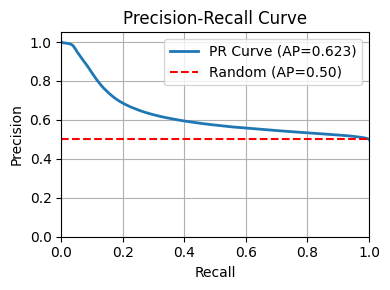

In [10]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_StarrSeq.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)
plot_pr_auc(seq_model, test_loader)

# Genomic promoter

In [11]:
BATCH_SIZE = 128
NUM_WORKERS = 103

In [12]:
train_transform = t.Compose(
    [
        t.ReverseComplement(0.5),
        t.Seq2Tensor(),
    ]
)
val_test_transform = t.Compose([t.Seq2Tensor()])

In [13]:
task = "genomicpromoter"
train_dataset = StarrSeqDataset(
    task=task, split="train", transform=train_transform, root="../data/"
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data/"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data/"
)

In [14]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 36898 (MpraDaraset)
    Number of datapoints: 36898
    Used split fold: train
Dataset StarrSeqDataset of size 4098 (MpraDaraset)
    Number of datapoints: 4098
    Used split fold: val
Dataset StarrSeqDataset of size 7285 (MpraDaraset)
    Number of datapoints: 7285
    Used split fold: test


In [15]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [16]:
in_channels = 4

model = HumanLegNet(
    in_ch=in_channels,
    output_dim=1,
    stem_ch=64,
    stem_ks=11,
    ef_ks=9,
    ef_block_sizes=[32, 64, 128, 128, 256, 512, 256],
    pool_sizes=[1, 2, 1, 2, 1, 2, 1],
    resize_factor=4,
)
model.apply(initialize_weights)

seq_model = LitModel_StarrSeq(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=10,
)

In [17]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_aupr", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=10,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.8845778703689575 | Val AUROC: 0.9521194696426392 | Val AUPR: 0.9559932947158813 |
| Val Precision: 0.8799421191215515 | Val Recall: 0.8906784057617188 | Val F1: 0.8852776885032654 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.8889498710632324 | Test AUROC: 0.9580546617507935 | Test AUPR: 0.9647675156593323 |
| Test Precision: 0.9353846311569214 | Test Recall: 0.8353943228721619 | Test F1: 0.8825663924217224 
----------------------------------------------------------------------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_aupr           0.9647675156593323
       test_auroc           0.9580546617507935
        test_loss           0.2787681818008423
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Class distribution: (array([0., 1.], dtype=float32), array([3646, 3639]))
Score range after sigmoid: [0.004, 1.000]


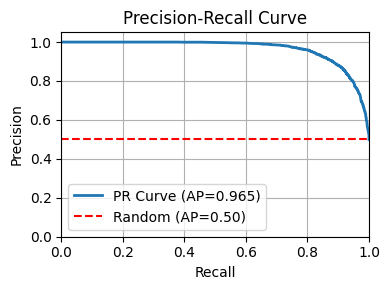

In [19]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_StarrSeq.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)
plot_pr_auc(seq_model, test_loader)

# Promoter capture

In [20]:
BATCH_SIZE = 512
NUM_WORKERS = 103
train_transform = t.Compose([t.Seq2Tensor()])
val_test_transform = t.Compose([t.Seq2Tensor()])

In [21]:
task = "CapturePromoter"

train_dataset = StarrSeqDataset(
    task=task, split="train", transform=train_transform, root="../data/"
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data/"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data/"
)

In [22]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 79732 (MpraDaraset)
    Number of datapoints: 79732
    Used split fold: train
Dataset StarrSeqDataset of size 13290 (MpraDaraset)
    Number of datapoints: 13290
    Used split fold: val
Dataset StarrSeqDataset of size 13290 (MpraDaraset)
    Number of datapoints: 13290
    Used split fold: test


In [23]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [24]:
in_channels = 4

model = HumanLegNet(
    in_ch=in_channels,
    output_dim=1,
    stem_ch=64,
    stem_ks=11,
    ef_ks=9,
    ef_block_sizes=[32, 64, 128, 128, 256, 512, 256],
    pool_sizes=[1, 2, 1, 2, 1, 2, 1],
    resize_factor=4,
)
model.apply(initialize_weights)

seq_model = LitModel_StarrSeq(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=10,
)

In [25]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_aupr", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=10,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.849510908126831 | Val AUROC: 0.9157829284667969 | Val AUPR: 0.897244930267334 |
| Val Precision: 0.8584657907485962 | Val Recall: 0.8370203375816345 | Val F1: 0.847607433795929 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.8463506102561951 | Test AUROC: 0.9238542318344116 | Test AUPR: 0.926335334777832 |
| Test Precision: 0.8575423359870911 | Test Recall: 0.8306998014450073 | Test F1: 0.8439076542854309 
----------------------------------------------------------------------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_aupr            0.926335334777832
       test_auroc           0.9238542318344116
        test_loss           0.3576887547969818
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Class distribution: (array([0., 1.], dtype=float32), array([6645, 6645]))
Score range after sigmoid: [0.000, 1.000]


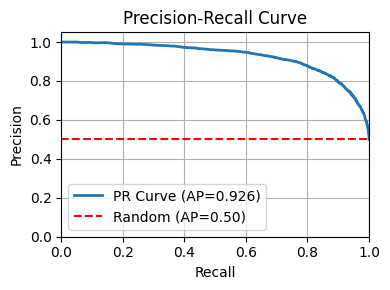

In [27]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_StarrSeq.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)
plot_pr_auc(seq_model, test_loader)

# Genomic enhancer

In [28]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([t.Seq2Tensor()])
val_test_transform = t.Compose([t.Seq2Tensor()])

In [29]:
task = "GenomicEnhancer"

train_dataset = StarrSeqDataset(
    task=task, split="train", transform=train_transform, root="../data/"
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data/"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data/"
)

In [30]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 323756 (MpraDaraset)
    Number of datapoints: 323756
    Used split fold: ['chr1', 'chr3', 'chr5', 'chr7', 'chr9', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Dataset StarrSeqDataset of size 89062 (MpraDaraset)
    Number of datapoints: 89062
    Used split fold: ['chr4', 'chr6', 'chr8']
Dataset StarrSeqDataset of size 99362 (MpraDaraset)
    Number of datapoints: 99362
    Used split fold: ['chr2', 'chr10', 'chr11']


In [31]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [32]:
in_channels = 4

model = HumanLegNet(
    in_ch=in_channels,
    output_dim=1,
    stem_ch=64,
    stem_ks=11,
    ef_ks=9,
    ef_block_sizes=[32, 64, 128, 128, 256, 512, 256],
    pool_sizes=[1, 2, 1, 2, 1, 2, 1],
    resize_factor=4,
)
model.apply(initialize_weights)

seq_model = LitModel_StarrSeq(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=10,
)

In [33]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_aupr", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=10,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [34]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.6591812372207642 | Val AUROC: 0.6850621700286865 | Val AUPR: 0.6966482400894165 |
| Val Precision: 0.768264651298523 | Val Recall: 0.39744383096694946 | Val F1: 0.5238737463951111 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.6610172986984253 | Test AUROC: 0.7104448080062866 | Test AUPR: 0.7073683142662048 |
| Test Precision: 0.7221073508262634 | Test Recall: 0.44997209310531616 | Test F1: 0.5544473528862 
----------------------------------------------------------------------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_aupr           0.7073683142662048
       test_auroc           0.7104448080062866
        test_loss            0.731259822845459
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Class distribution: (array([0., 1.], dtype=float32), array([52788, 46574]))
Score range after sigmoid: [0.005, 1.000]


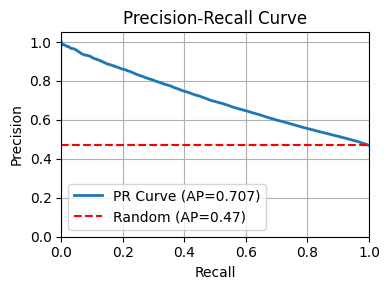

In [35]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_StarrSeq.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)
plot_pr_auc(seq_model, test_loader)

# ATACseq

In [4]:
BATCH_SIZE = 2048
NUM_WORKERS = 103
train_transform = t.Compose([t.Seq2Tensor()])
val_test_transform = t.Compose([t.Seq2Tensor()])

In [5]:
task = "atacseq"

train_dataset = StarrSeqDataset(
    task=task, split="train", transform=train_transform, root="../data/"
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data/"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data/"
)

In [6]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 2712578 (MpraDaraset)
    Number of datapoints: 2712578
    Used split fold: ['chr1', 'chr3', 'chr5', 'chr7', 'chr9', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Dataset StarrSeqDataset of size 910186 (MpraDaraset)
    Number of datapoints: 910186
    Used split fold: ['chr4', 'chr6', 'chr8']
Dataset StarrSeqDataset of size 912794 (MpraDaraset)
    Number of datapoints: 912794
    Used split fold: ['chr2', 'chr10', 'chr11']


In [7]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [8]:
in_channels = 4

model = HumanLegNet(
    in_ch=in_channels,
    output_dim=1,
    stem_ch=64,
    stem_ks=11,
    ef_ks=9,
    ef_block_sizes=[32, 64, 128, 128, 256, 512, 256],
    pool_sizes=[1, 2, 1, 2, 1, 2, 1],
    resize_factor=4,
)
model.apply(initialize_weights)

seq_model = LitModel_StarrSeq(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=2,
)

In [9]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_aupr", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=10,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 1 | Val Acc: 0.624670147895813 | Val AUROC: 0.8043653964996338 | Val AUPR: 0.7955533266067505 |
| Val Precision: 0.5761393904685974 | Val Recall: 0.9436972141265869 | Val F1: 0.7154731750488281 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 3 | Val Acc: 0.8078107237815857 | Val AUROC: 0.887643575668335 | Val AUPR: 0.9061355590820312 |
| Val Precision: 0.874871551990509 | Val Recall: 0.7184178233146667 | Val F1: 0.7889631986618042 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 5 | Val Acc: 0.7905406355857849 | Val AUROC: 0.8715121746063232 | Val AUPR: 0.8941831588745117 |
| Val Precision: 0.8981344103813171 | Val Recall: 0.6554731726646423 | Val F1: 0.7578529119491577 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 7 | Val Acc: 0.7782090902328491 | Val AUROC: 0.853588342666626 | Val AUPR: 0.8731025457382202 |
| Val Precision: 0.9170330166816711 | Val Recall: 0.6118234395980835 | Val F1: 0.7339633703231812 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.7731496691703796 | Val AUROC: 0.8193956613540649 | Val AUPR: 0.8304080963134766 |
| Val Precision: 0.9099487662315369 | Val Recall: 0.6063593029975891 | Val F1: 0.7277622222900391 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.7883903980255127 | Test AUROC: 0.8700599074363708 | Test AUPR: 0.8948275446891785 |
| Test Precision: 0.8559738993644714 | Test Recall: 0.7076529860496521 | Test F1: 0.7747787833213806 
----------------------------------------------------------------------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_aupr           0.8948275446891785
       test_auroc           0.8700599074363708
        test_loss           0.4786107838153839
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Class distribution: (array([0., 1.], dtype=float32), array([443304, 469490]))
Score range after sigmoid: [0.000, 1.000]


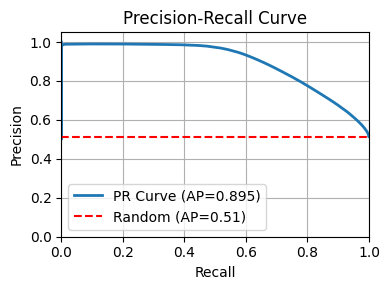

In [11]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_StarrSeq.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)
plot_pr_auc(seq_model, test_loader)

# Binary task

In [12]:
class HumanLegNetBinary(HumanLegNet):
    def __init__(
        self,
    ):
        super().__init__(
            in_ch=4,
            output_dim=1,
            stem_ch=64,
            stem_ks=11,
            ef_ks=9,
            ef_block_sizes=[80, 96, 112, 128],
            pool_sizes=[2, 2, 2, 2],
            resize_factor=4,
            activation=nn.SiLU,
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.main(x)
        x = self.mapper(x)
        x = F.adaptive_avg_pool1d(x, 1)
        x = x.squeeze(-1)  # without head
        # x = self.head(x)
        # x = x.squeeze(-1)
        return x

In [13]:
class LitModel_StarrSeq_binary(LitModel_StarrSeq):
    def __init__(
        self, weight_decay, lr, model=None, loss=nn.BCEWithLogitsLoss(), print_each=1
    ):
        super().__init__(
            model=model,
            loss=loss,
            print_each=print_each,
            weight_decay=weight_decay,
            lr=lr,
        )
        self.output_dim = 1

        out_ch = 256

        activation = nn.SiLU

        self.head = nn.Sequential(
            nn.Linear(out_ch * 2, out_ch),
            nn.BatchNorm1d(out_ch),
            activation(),
            nn.Linear(out_ch, self.output_dim),
        )

    def _process_batch(self, batch):
        seqs, labels = batch
        enhancer = self.model(seqs["seq_enh"])
        promoter = self.model(seqs["seq"])

        concat = torch.cat([enhancer, promoter], dim=1)

        out = self.head(concat).squeeze(-1)
        return out, labels

    def training_step(self, batch, batch_nb):
        y_hat, y = self._process_batch(batch)

        loss = self.loss(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self._process_batch(batch)
        loss = self.loss(y_hat, y)

        self.val_acc(y_hat, y)
        self.val_auroc(y_hat, y)
        self.val_aupr(y_hat, y.long())
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        y_hat, y = self._process_batch(batch)

        loss = self.loss(y_hat, y)

        self.test_acc(y_hat, y)
        self.test_auroc(y_hat, y)
        self.test_aupr(y_hat, y.long())
        self.test_precision(y_hat, y)
        self.test_recall(y_hat, y)
        self.test_f1(y_hat, y)

        self.log("test_loss", loss, on_epoch=True, prog_bar=True)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        y_hat, y = self._process_batch(batch)

        return {
            "predicted": y_hat.squeeze().cpu().detach(),
            "target": y.cpu().detach().float(),
        }

In [14]:
BATCH_SIZE = 1024
NUM_WORKERS = 103

train_transform = t.Compose(
    [
        t.Seq2Tensor(),
    ]
)
val_test_transform = t.Compose([t.Seq2Tensor()])

In [15]:
binary_train = ["promoter_from_input", "enhancer_permutated", "enhancer_from_input"]
task = tasks[6]

train_dataset = StarrSeqDataset(
    task=task,
    binary_class=None,
    split="train",
    transform=train_transform,
    root="../data/",
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data/"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data/"
)

using train
using val
using test


In [16]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 2991302 (MpraDaraset)
    Number of datapoints: 2991302
    Used split fold: train
Dataset StarrSeqDataset of size 748828 (MpraDaraset)
    Number of datapoints: 748828
    Used split fold: val
Dataset StarrSeqDataset of size 1252044 (MpraDaraset)
    Number of datapoints: 1252044
    Used split fold: test


In [17]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [18]:
model = HumanLegNetBinary()
model.apply(initialize_weights)

seq_model = LitModel_StarrSeq_binary(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=2,
)

In [21]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_aupr", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=10,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [22]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 1 | Val Acc: 0.7614418864250183 | Val AUROC: 0.843306839466095 | Val AUPR: 0.8518325686454773 |
| Val Precision: 0.7437492609024048 | Val Recall: 0.7977346181869507 | Val F1: 0.76979660987854 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 3 | Val Acc: 0.7819820046424866 | Val AUROC: 0.8561155796051025 | Val AUPR: 0.8650144338607788 |
| Val Precision: 0.7897835373878479 | Val Recall: 0.7685209512710571 | Val F1: 0.7790071964263916 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 5 | Val Acc: 0.7839810848236084 | Val AUROC: 0.8584768772125244 | Val AUPR: 0.8684882521629333 |
| Val Precision: 0.7893828749656677 | Val Recall: 0.7746478319168091 | Val F1: 0.7819459438323975 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 7 | Val Acc: 0.7889528870582581 | Val AUROC: 0.863614559173584 | Val AUPR: 0.8734046220779419 |
| Val Precision: 0.7946954369544983 | Val Recall: 0.7792096734046936 | Val F1: 0.786876380443573 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.7869764566421509 | Val AUROC: 0.862263560295105 | Val AUPR: 0.8717173337936401 |
| Val Precision: 0.7875816822052002 | Val Recall: 0.7859241366386414 | Val F1: 0.7867520451545715 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.7883748412132263 | Test AUROC: 0.8629711866378784 | Test AUPR: 0.872755229473114 |
| Test Precision: 0.7940240502357483 | Test Recall: 0.7787681818008423 | Test F1: 0.7863221168518066 
----------------------------------------------------------------------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_aupr            0.872755229473114
       test_auroc           0.8629711866378784
        test_loss           0.46843859553337097
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Class distribution: (array([0., 1.], dtype=float32), array([626022, 626022]))
Score range after sigmoid: [0.000, 1.000]


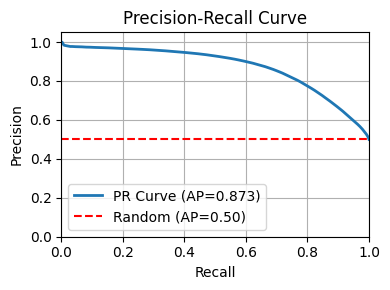

In [23]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_StarrSeq_binary.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)
plot_pr_auc(seq_model, test_loader)